In [1]:
import numpy as np
import matplotlib.pyplot as plt
from multiprocessing import Pool, cpu_count
print('There are: '+str(cpu_count()) + ' CPUs')
import pickle
from scipy.interpolate import interp1d
from functions import *
from pathlib import Path
import matplotlib.patheffects as pe

There are: 6 CPUs


/Data/meech/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/least_angle.py:30: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  method='lar', copy_X=True, eps=np.finfo(np.float).eps,
/Data/meech/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/least_angle.py:167: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  method='lar'

In [2]:
from tqdm import tqdm

In [3]:
import emcee
import corner

## Load data

In [140]:
# input spirou data - it's inj_amp = 3. (cross-correlation non-detection)

# define data params
instrument = 'igrins'
inject     = True
use_masked = True
sp         = 'H2O'

if inject:
    inj_amp  = 1.
    inj_Kp   = 83. # km/s
    inj_vsys = -4.71
    df       = 'inject_amp{:.1f}_Kp{:.1f}_vsys{:.2f}_{}'.format(inj_amp,inj_Kp,inj_vsys,sp)
else:
    inj_Kp   = 83.
    inj_vsys = -4.71
    df       = 'true_data'
if use_masked:
    mk       = 'masked/'
else:
    mk       = ''
if instrument=='igrins':
    bl       = 'blazed/'
else:
    bl       = ''


datafile = 'Input_data/{}/{}/{}airmass_deg2/PCA/residual_sampling/noLS/reduced_1.pkl'.format(instrument,df,bl)
with open(datafile,'rb') as specfile:
    A = pickle.load(specfile)
orders,WW,Ir,T_obs,phase,window,berv,vstar,airmass,SN,SNR_mes,SNR_mes_pca,Imask,mask = A

In [141]:
datafile

'Input_data/igrins/inject_amp1.0_Kp83.0_vsys-4.71_H2O/blazed/airmass_deg2/PCA/residual_sampling/noLS/reduced_1.pkl'

In [142]:
# forward model
mod_file  = 'Models/1x_metallicity_1.0_CO_ratio/pRT_data_full_{}.dat'.format(sp)
W_mod     = []
T_depth   = []
with open(mod_file, 'r') as data:
    lines = data.readlines()
    data.close()
for line in lines[4:]:
    v = line.split(' ')
    W_mod.append(float(v[0]))
    T_depth.append(float(v[1].split('\n')[0]))
W_mod = np.array(W_mod)/1e3
T_depth = np.array(T_depth)
T_depth = (inj_amp*(T_depth-1))

In [143]:
# create order objects
list_ord = []
nord = len(orders)
for nn in range(nord):
    O        = Order(orders[nn])
    O.W_fin  = np.array(WW[nn],dtype=float)
    O.W_fin  /= 1e3 # hack to convert to um (make universal later)
    O.SNR    = np.array(SN[nn],dtype=float)
    O.W_mean = O.W_fin.mean()
    if use_masked:
        O.I_pca = np.array(Imask[nn],dtype=float)
    else:
        O.I_pca  = np.array(Ir[nn],dtype=float)

    ### purge NaNs
    l = np.ones_like(O.W_fin,'bool')
    for ipix in range(len(O.I_pca[0])):
        if np.isnan(O.I_pca[:,ipix]).any():
            l[ipix] = False
    O.W_fin = O.W_fin[l]
    O.I_pca = O.I_pca[:,l]
    Wmin,Wmax = 0.95*O.W_fin.min(),1.05*O.W_fin.max()
    indm      = np.where((W_mod>Wmin)&(W_mod<Wmax))[0]
    O.Wm      = W_mod#indm]
    O.Im      = T_depth#[indm]

    list_ord.append(O)

## Define prior and Loglikelihood

In [144]:
##########################################
##### Define Prior and Loglikelihood #####
##########################################

# theta:
# - kp
# - vsys
# - a (scaling parameter)

#concatenate all orders (later choose orders)

c0 = 299792.458 # km/s
for nn in range(len(list_ord)):
    O     = list_ord[nn]
    if nn==0:
        flux = O.I_pca
        wlens = O.W_fin
    else:
        flux = np.concatenate((flux,O.I_pca),axis=1)
        wlens = np.concatenate((wlens,O.W_fin),axis=0)

nep,npix = flux.shape
print(nep,npix)
f = flux - np.nanmean(flux, axis=1)[:, np.newaxis]
f2 = np.nansum(f**2, axis=1)

pscale = np.sin(2*np.pi*phase)
Vshift = vstar-berv
if inject:
    Vshift -= -4.71 # hack for the cross-correlation bc otherwise true vsys is added

# the forward model
planetspec = interp1d(O.Wm,O.Im)

def prior(theta):
    
    # stop velocity wandering off
    if theta[0]>200 or theta[0]<0: return False
    if theta[1]>60 or theta[1]<-60: return False
    
    return True

def log_prob(theta):

    if prior(theta)==False: return - np.inf
    
    Kp = theta[0]
    Vsys = theta[1]

    # interpolate model
    mod = np.zeros(flux.shape)
    for iep in range(nep):
        mod[iep] = planetspec(wlens*( 1 - (Vsys + Kp*pscale[iep] + Vshift[iep])/c0)) # taylor expansion (rather than division)
    
    g = mod - np.nanmean(mod, axis=1)[:, np.newaxis]
    #g /= np.nanstd(mod, axis=1)[:, np.newaxis]
    
    fg = np.nansum(f*g, axis=1)
    g2 = np.nansum(g**2, axis=1)
    logl = - npix/2 * np.nansum( np.log(1/npix * (f2 - 2*fg + g2)) )

    return logl

125 65080


## Try grid of velocities



In [145]:
# first search for file
save_dir = 'xcorr_result/{}/1x_metallicity_1.0_CO_ratio/{}/{}airmass_deg2/PCA/residual_sampling/noLS/likelihood/{}'.format(instrument,df,bl,mk)
nam_res  = save_dir + 'grid_{}.pkl'.format(sp)
if Path(nam_res).is_file():
    print('loading file')
    with open(nam_res, 'rb') as specfile:
        l_kp,l_kv_sys,lik = pickle.load(specfile)
else:
    if not os.path.exists(save_dir): os.makedirs(save_dir)
        
    # instead of MCMC step through a grid of velocities:
    l_kp = np.arange(0,150,2)
    l_kv_sys = np.arange(-30,30,0.5)
    lik = np.zeros((len(l_kv_sys), len(l_kp)))
    for j in tqdm(range(len(l_kp))):
        for k in range(len(l_kv_sys)):
            lik[k,j] = log_prob([l_kp[j], l_kv_sys[k]])
    ## save results
    # Kp_grid, Vsys_grid, likelihoods
    A = (l_kp,l_kv_sys,lik)
    with open(nam_res,'wb') as specfile:
        pickle.dump(A,specfile)

100%|██████████| 75/75 [47:05<00:00, 40.51s/it]


/Data/meech/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: The following kwargs were not used by contour: 'aspect'
  


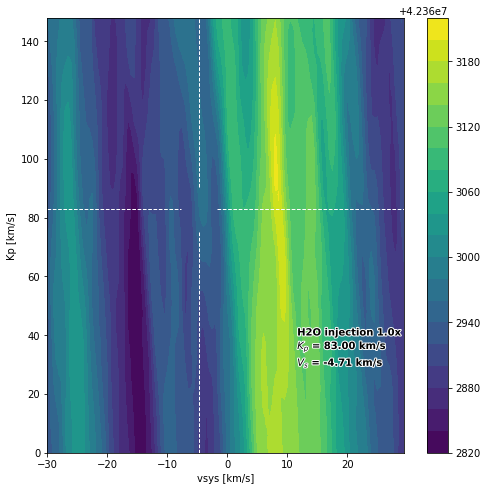

In [146]:
fig = plt.figure(figsize=(8,8))
plt.contourf(l_kv_sys,l_kp,lik.T,aspect='auto',levels=20)
plt.xlabel('vsys [km/s]')
plt.ylabel('Kp [km/s]')
plt.colorbar()

width  = 0.1*np.ptp(l_kv_sys)
height = 0.1*np.ptp(l_kp)
plt.hlines(inj_Kp, l_kv_sys.min(), inj_vsys-0.5*width,ls='--',lw=1.0,color='w')
plt.hlines(inj_Kp, inj_vsys+0.5*width, l_kv_sys.max(),ls='--',lw=1.0,color='w')
plt.vlines(inj_vsys, l_kp.min(), inj_Kp-0.5*height,ls='--',lw=1.0,color='w')
plt.vlines(inj_vsys, inj_Kp+0.5*height, l_kp.max(),ls='--',lw=1.0,color='w')


if inject:
    text_title = '{} injection {}x \n$K_p$ = {:.2f} km/s \n$V_s$ = {:.2f} km/s'.format(sp,inj_amp,inj_Kp,inj_vsys)
else:
    text_title = '{} true data \n$K_p$ = {:.2f} km/s \n$V_s$ = {:.2f} km/s'.format(sp,inj_Kp,inj_vsys)
rKp = l_kp.max()-l_kp.min()
rVsys = l_kv_sys.max()-l_kv_sys.min()

fig.patch.set_facecolor('white')
plt.text(l_kv_sys.max()-0.3*rVsys,l_kp.min()+0.2*rKp,text_title,color='k',weight='bold',path_effects=[pe.withStroke(linewidth=2,foreground='white')])
plt.savefig(save_dir+'ll_grid_{}.png'.format(sp),transparent=False)

## MCMC over velocities


In [147]:
# first search for file
save_dir = 'xcorr_result/{}/1x_metallicity_1.0_CO_ratio/{}/{}airmass_deg2/PCA/residual_sampling/noLS/likelihood/{}'.format(instrument,df,bl,mk)
nam_res2  = save_dir + 'mcmc_{}.pkl'.format(sp)
if Path(nam_res2).is_file():
    print('loading file')
    with open(nam_res2, 'rb') as specfile:
        labels,samples,flat_samples,n,chain_prob = pickle.load(specfile)
else:
    #####################################
    ##### Initial params and labels #####
    #####################################

    med = [inj_Kp, inj_vsys]
    std = [1e-4, 1e-4]

    labels = ['Kp', 'Vsys']
    ###############################
    ##### Run MCMC (too slow) #####
    ###############################
    ndim, nwalkers = 2, 30 # for now just fit velocity
    p0 = np.random.randn(nwalkers, ndim)
    for i in range(ndim):
        p0[:,i] = p0[:,i]*std[i] + med[i]

    with Pool() as pool:
        sampler = emcee.EnsembleSampler(nwalkers, ndim, log_prob, pool=pool)
        sampler.run_mcmc(p0, 2000, progress=True)
    ## save results
    # parameters, all samples, flat samples without burn in, burn in, log_likelihood
    A = (labels,samples,flat_samples,n,chain_prob)
    with open(nam_res2,'wb') as specfile:
        pickle.dump(A,specfile)

100%|██████████| 2000/2000 [2:37:27<00:00,  4.10s/it]  


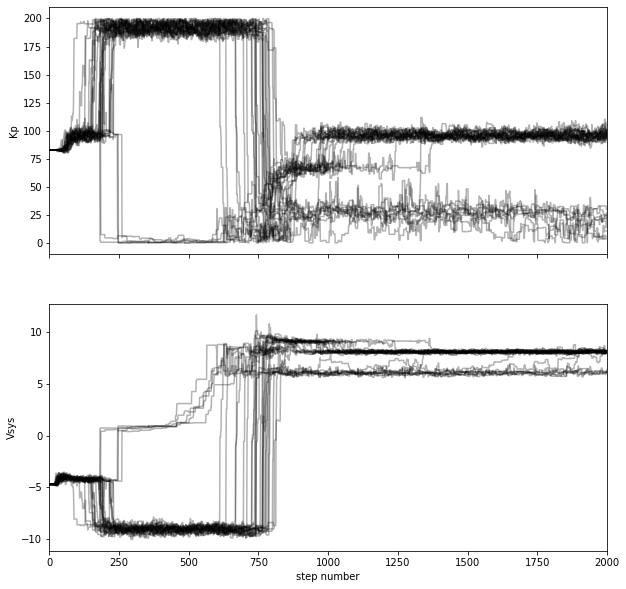

In [148]:
#############################
##### Check MCMC chains #####
#############################

fig, axes = plt.subplots(ndim, figsize=(10, 10), sharex=True)
samples = sampler.get_chain()
cut=0 #remove initial n steps from plot

for i in range(ndim):
    ax = axes[i]
    ax.plot(np.arange(len(samples))[cut:], samples[cut:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])

axes[-1].set_xlabel("step number")
fig.patch.set_facecolor('white')
plt.savefig(save_dir+'chains_{}.png'.format(sp))
plt.show()
plt.close()
# samples have shape nstep,nwalkers,ndim


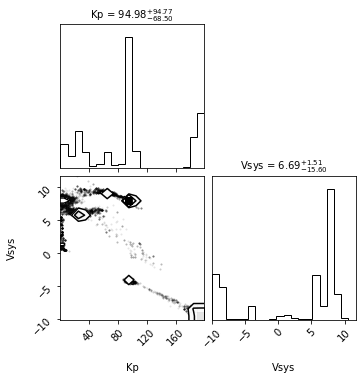

In [149]:
###############################
##### Plot output of MCMC #####
###############################

n = 100 #burn in
flat_samples = sampler.get_chain(discard=n, flat=True)
figure = corner.corner(flat_samples, labels=labels, show_titles=True, title_kwargs={"fontsize": 10})
figure.patch.set_facecolor('white')
plt.savefig(save_dir+'corner_{}.png'.format(sp))
plt.show()
plt.close()

hd = ''
for l in labels: hd += l +','
#np.savetxt('./chains.csv', flat_samples, delimiter=",", header=hd[:-1])

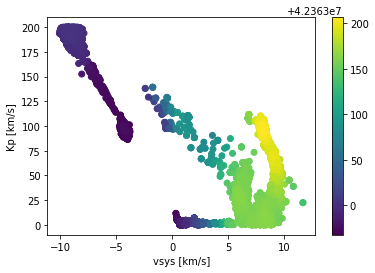

In [150]:
chain_prob = sampler.get_log_prob(discard=n, flat=True)
fig = plt.figure()
plt.scatter(flat_samples[:,1],flat_samples[:,0], c=chain_prob)
fig.patch.set_facecolor('white')
plt.xlabel('vsys [km/s]')
plt.ylabel('Kp [km/s]')
plt.colorbar()
plt.savefig(save_dir+'likelihood_mcmc_{}.png'.format(sp))

### Combine likelihoods for IGRINS and SPIRou

In [ ]:
# open results file
# choose injection params
inj_amp  = 1.
inj_Kp   = 83.
inj_vsys = -4.71
sp       = 'CH4'
inject   = True
if inject:
    df   = 'inject_amp{:.1f}_Kp{:.1f}_vsys{:.2f}_{}'.format(inj_amp,inj_Kp,inj_vsys,sp)
else:
    df   = 'true_data'

instr = ['spirou','igrins']
for i in range(len(instr)):
    save_dir = 'xcorr_result/{}/1x_metallicity_1.0_CO_ratio/{}/airmass_deg2/PCA/residual_sampling/noLS/likelihood/{}'.format(instr[i],df,mk)
    nam_res2  = save_dir + 'mcmc_{}.pkl'.format(sp)
    with open(nam_res2,'rb') as specfile:
        A = pickle.load(specfile)
    labels,samples,flat_samples,n,chain_prob = A